In [9]:
import geopandas as gpd 
import numpy as np 
import os
import matplotlib.pyplot as plt 
import rasterio as rio 
import rioxarray as rioxr
import pandas as pd
import xarray as xr
import pandas
import pickle
import seaborn as sns

In [10]:
project_dir = "/home/rustt/Documents/Projects/S1_S2_classification"
data_dir = os.path.join(project_dir, "sentinel_classification/data/processed")
model_dir = os.path.join(project_dir, "sentinel_classification/models")
out_dir = os.path.join(project_dir, "sentinel_classification/reports")
s2_stack = rioxr.open_rasterio(os.path.join(data_dir, "s2", "clip_s2_pan_sharp.tif"))

In [11]:
ds_s2_stack = s2_stack.to_dataset(dim="band")
#del s2_stack

In [4]:
# load rf
with open(os.path.join(model_dir, "rf_sk_baseline_rsmpl.pkl"), "rb") as fp:
    rf_clf = pickle.load(fp)

In [5]:
# read labels encoder
with open(os.path.join(model_dir, "encoder_labels.pkl"), "rb") as fp: 
    labels_encoder = pickle.load(fp)

In [37]:
# read labels mapping
with open(os.path.join(data_dir, "labels_mapping.pkl"), "rb") as fp: 
    labels_mapping = pickle.load(fp)

In [6]:
rf_clf

RandomForestClassifier(n_jobs=-1)

In [15]:
X_arr = s2_stack.to_numpy()

In [16]:
X_arr.shape

(10, 4011, 5592)

In [ ]:
X_arr = X_arr.transpose((1, 2, 0))
X_arr = X_arr.reshape(-1, 10)

In [19]:
X_arr.shape

(22429512, 10)

Predict by batch to not overload ram

In [26]:
%%time
sz_chunk =  2_000_000
n_chunk = X_arr.shape[0] // sz_chunk
lc_arr = []
for arr in np.array_split(X_arr, n_chunk):
    lc_arr.append(rf_clf.predict(arr))
lc_arr = np.hstack(lc_arr)

CPU times: user 10min 32s, sys: 1min 48s, total: 12min 20s
Wall time: 1min 5s


In [21]:
lc_arr.shape

(22429512,)

In [31]:
lc_arr = labels_encoder.inverse_transform(lc_arr)

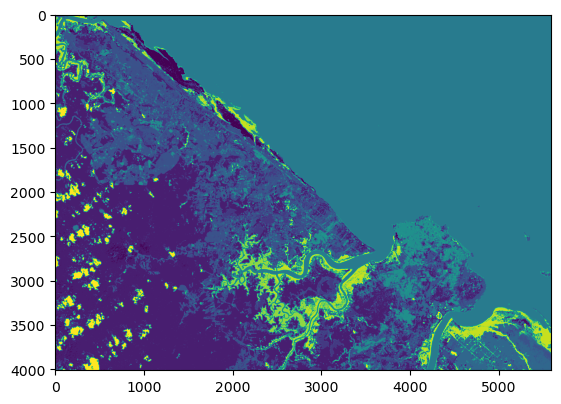

In [25]:
plt.imshow(lc_arr)

In [42]:
cnt_classes_lc = pd.Series(lc_arr).value_counts(dropna=False).sort_index()

In [43]:
cnt_classes_lc.shape

(10,)

In [45]:
for lc_idx, lc_cnt in cnt_classes_lc.items(): 
    print(f"{labels_mapping[lc_idx]} : {lc_cnt} px")

1 - coastal mangrove : 587289 px
2 - forest : 6049686 px
3 - swamps : 367680 px
4 - herbaceous savana : 2738938 px
5 - bare soil : 631341 px
6 - water : 9749409 px
7 - building area : 678256 px
11 - low mangrove : 322709 px
12 - high mangrove : 947525 px
13 - clouds : 356679 px


## Save as raster

In [36]:
with rio.open(os.path.join(data_dir, "s2", "clip_s2_pan_sharp.tif")) as rs_src: 
    meta = rs_src.meta.copy()
    rs_arr = lc_arr.reshape((rs_src.height, rs_src.width))
    new_meta = dict(
        count=1,
    )
    new_meta = {**meta, **new_meta}
    with rio.open(os.path.join(out_dir, "lc_rf_s2_baseline.tif"), mode="w+", **new_meta) as rs_lc: 
        rs_lc.write(rs_arr, 1)
        